In [1]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
data_dir = os.path.dirname(os.getcwd())+'/images'
data_dir

'/home/javier.luna/Desktop/proyecto_pandas/images'

In [3]:
data_dir = pathlib.Path(data_dir)

In [4]:
pandas = list(data_dir.glob('panda/*'))

In [5]:
#PIL.Image.open(str(pandas[0]))

In [6]:
#PIL.Image.open(str(pandas[1]))

# Create a dataset

In [7]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [8]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 187 files belonging to 2 classes.
Using 150 files for training.


In [9]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 187 files belonging to 2 classes.
Using 37 files for validation.


In [10]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [11]:
class_names = train_dataset.class_names
class_names

['not_panda', 'panda']

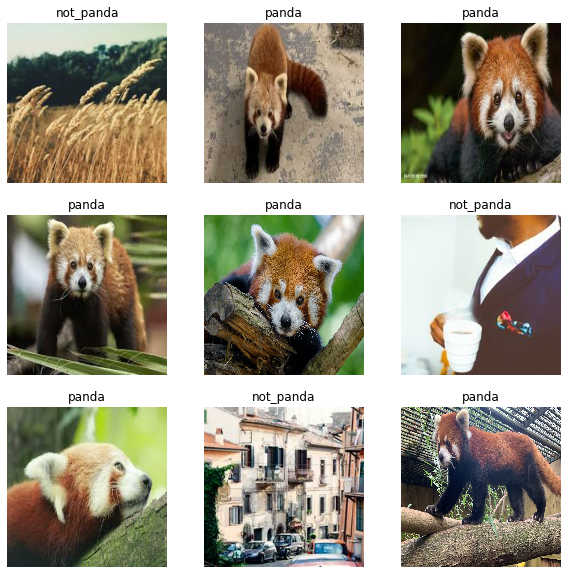

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Configure dataset for performance

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Data augmentation

In [14]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomTranslation(
    height_factor=0.2,
    width_factor=0.1)
])

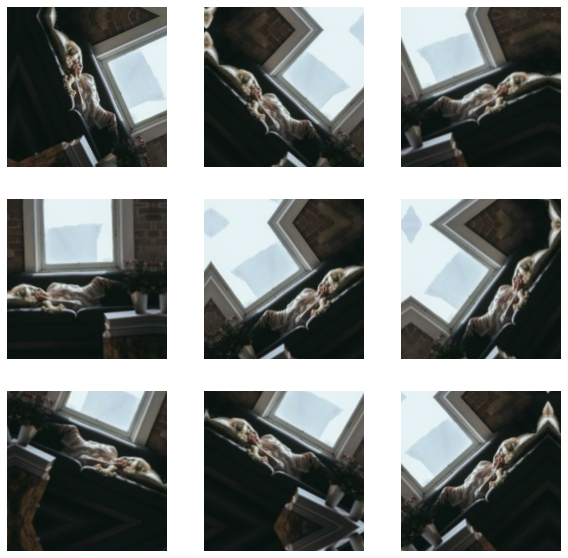

In [15]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [16]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


## Create the base model from the pre-trained model MobileNet V2


In [17]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

## Feature extraction

In [18]:
base_model.trainable = False


In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)


In [20]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [21]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train the model

In [22]:
initial_epochs = 10
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                   callbacks=[callback])

Epoch 1/10
5/5 [==============================] - 3s 349ms/step - loss: 0.7871 - accuracy: 0.5067 - val_loss: 0.9014 - val_accuracy: 0.3514
Epoch 2/10
5/5 [==============================] - 1s 229ms/step - loss: 0.8237 - accuracy: 0.4933 - val_loss: 0.8619 - val_accuracy: 0.4865
Epoch 3/10
5/5 [==============================] - 2s 295ms/step - loss: 0.7565 - accuracy: 0.5200 - val_loss: 0.8253 - val_accuracy: 0.4865
Epoch 4/10
5/5 [==============================] - 1s 225ms/step - loss: 0.6904 - accuracy: 0.5400 - val_loss: 0.7910 - val_accuracy: 0.4595
Epoch 5/10
5/5 [==============================] - 1s 224ms/step - loss: 0.7158 - accuracy: 0.5267 - val_loss: 0.7598 - val_accuracy: 0.4595
Epoch 6/10
5/5 [==============================] - 1s 221ms/step - loss: 0.6647 - accuracy: 0.6267 - val_loss: 0.7310 - val_accuracy: 0.4595
Epoch 7/10
5/5 [==============================] - 1s 221ms/step - loss: 0.5843 - accuracy: 0.6000 - val_loss: 0.7041 - val_accuracy: 0.4865
Epoch 8/10
5/5 [====

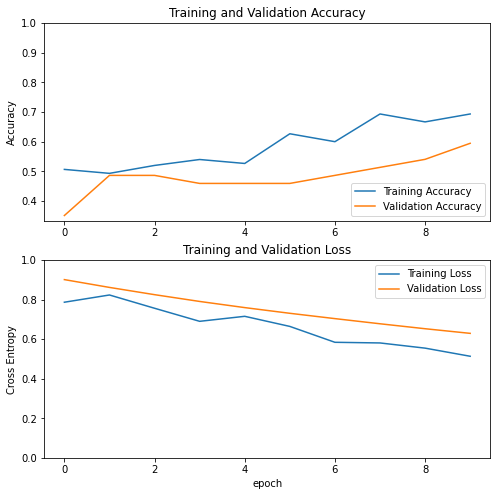

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning

In [24]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [25]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [26]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                        callbacks=[callback])

Epoch 10/20
5/5 [==============================] - 5s 465ms/step - loss: 0.3431 - accuracy: 0.8333 - val_loss: 0.2935 - val_accuracy: 0.8649
Epoch 11/20
5/5 [==============================] - 2s 316ms/step - loss: 0.1599 - accuracy: 0.9533 - val_loss: 0.2166 - val_accuracy: 0.9189
Epoch 12/20
5/5 [==============================] - 2s 311ms/step - loss: 0.1439 - accuracy: 0.9533 - val_loss: 0.1906 - val_accuracy: 0.9459
Epoch 13/20
5/5 [==============================] - 2s 315ms/step - loss: 0.1123 - accuracy: 0.9733 - val_loss: 0.1349 - val_accuracy: 0.9459
Epoch 14/20
5/5 [==============================] - 2s 315ms/step - loss: 0.0664 - accuracy: 0.9933 - val_loss: 0.1184 - val_accuracy: 0.9459
Epoch 15/20
5/5 [==============================] - 2s 313ms/step - loss: 0.0616 - accuracy: 0.9867 - val_loss: 0.1076 - val_accuracy: 0.9730
Epoch 16/20
5/5 [==============================] - 2s 313ms/step - loss: 0.0496 - accuracy: 0.9800 - val_loss: 0.1010 - val_accuracy: 0.9730
Epoch 17/20
5

In [27]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

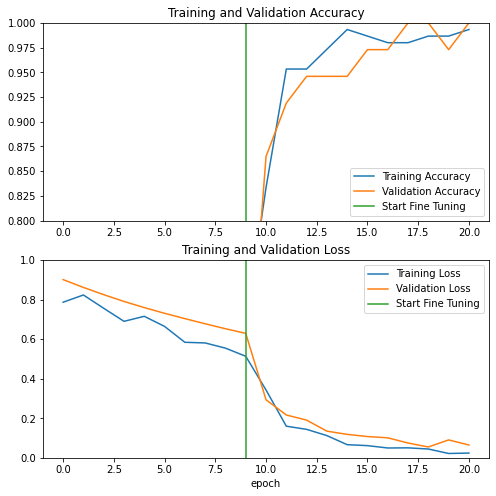

In [28]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [29]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

/home/javier.luna/.local/lib/python3.8/site-packages/keras/utils/generic_utils.py:923: RuntimeWarning: divide by zero encountered in log10
  numdigits = int(np.log10(self.target)) + 1


OverflowError: cannot convert float infinity to integer

Predictions:
 [1 0 1 0 0 1 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 1 0 1 1]
Labels:
 [1 0 1 0 0 1 1 1 0 1 0 0 0 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 1 0 1 1]


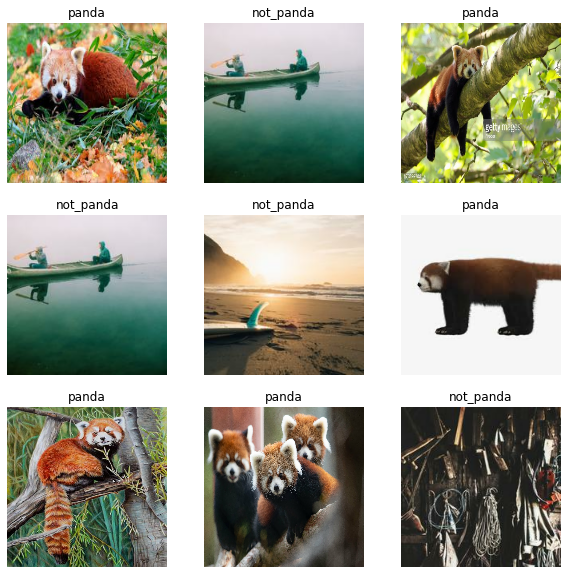

In [30]:
# Retrieve a batch of images from the test set
image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

# Predict on single image

In [33]:
!pip install opencv-python
import cv2


In [55]:
img = cv2.imread('./TEST.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img2= cv2.resize(img, IMG_SIZE)
img2=np.expand_dims(img2, axis=0)

In [56]:
IMG_SIZE

(160, 160)

In [57]:
img2.shape

(1, 160, 160, 3)

In [58]:
prediction = model.predict(img2).flatten()
prediction = tf.nn.sigmoid(prediction)
prediction = tf.where(prediction < 0.5, 0, 1)

In [59]:
prediction

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>

(-0.5, 1079.5, 1032.5, -0.5)

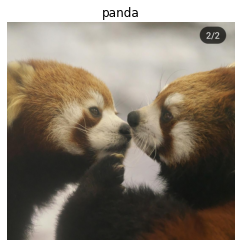

In [60]:
plt.imshow(img.astype("uint8"))
plt.title(class_names[prediction[0]])
plt.axis("off")

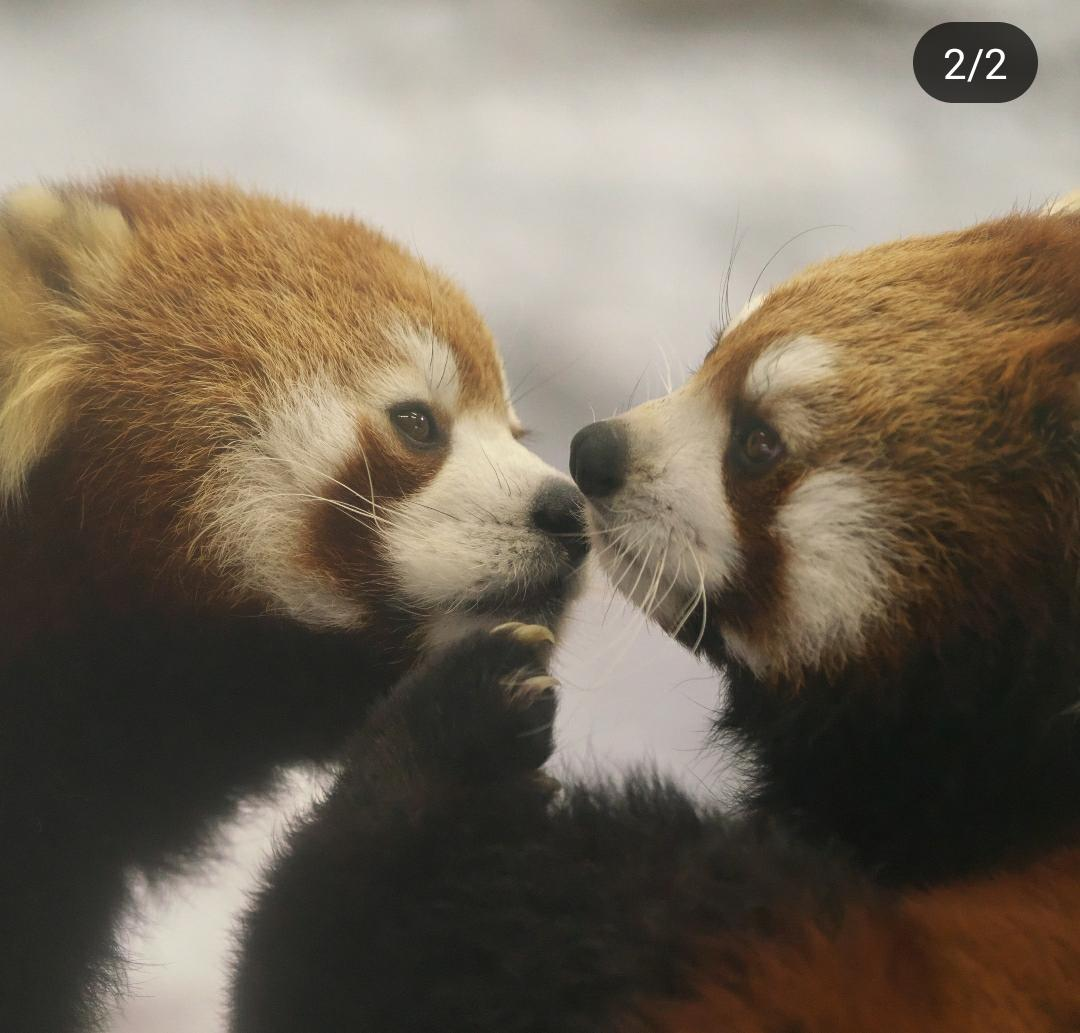

In [50]:
PIL.Image.open(str('./TEST.jpg'))

In [52]:
cv2.imshow('image',img)

In [ ]:
prediction

In [ ]:
prediction[0]

In [ ]:
class_names[prediction[0]]

In [ ]:
class_names[0]

In [53]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)